# Mapping Deprived Area

In [1]:
# import libraries

import sys
import numpy as np
import pandas as pd
from osgeo import gdal
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os

import utils
import util_preprocess

## Set working directory

In [2]:
# Get abosolute path of the current folder
FPATH = '/media/owusu/Extreme SSD/IDEAMAPS/Training_Dataset/Accra'

# Get abosolute output path of te current folder
OUTPUT = '/media/owusu/Extreme SSD/IDEAMAPS/Training_Dataset/Accra/'

target = 'class'

# Random seed
random_seed = 42
# Set random seed in numpy
np.random.seed(random_seed)

## Load covariate features

In [14]:
PATH= f'/media/owusu/Extreme SSD/IDEAMAPS/covariate_feature_53bands/lag_covariate_compilation_53bands.tif'
img = utils.read_image(PATH)
img_arr=img[0]
img_gt=img[1]
img_georef=img[2]

# Process spfea features, get the width, height and number of bands
n = img_arr.shape[0]
print (n) # number of bands
h = img_arr.shape[1]
print (h) # height
w = img_arr.shape[2]
print (w) # width

53
685
1993


## Convert covariate array to pandas dataframe

In [15]:
bandname = ['fs_dist_fs_2020', 'fs_dist_school_2020', 'in_dist_rd_2016', 'in_dist_rd_intersect_2016', 'in_dist_waterway_2016', 'in_night_light_2016',
'ph_base_water_2010', 'ph_bio_dvst_2015', 'ph_climate_risk_2020', 'ph_dist_aq_veg_2015', 'ph_dist_art_surface_2015', 'ph_dist_bare_2015',
'ph_dist_cultivated_2015', 'ph_dist_herb_2015', 'ph_dist_inland_water_2018', 'ph_dist_open_coast_2020', 'ph_dist_shrub_2015', 'ph_dist_sparse_veg_2015',
'ph_dist_woody_tree_2015', 'ph_gdmhz_2005', 'ph_grd_water_2000', 'ph_hzd_index_2011', 'ph_land_c1_2019', 'ph_land_c2_2020', 'ph_max_tem_2019',
'ph_ndvi_2019', 'ph_pm25_2016', 'ph_slope_2000', 'ses_an_visits_2016', 'ses_child_stunted_2016', 'ses_dpt3_2016', 'ses_hf_delivery_2016',
'ses_impr_water_src_2016', 'ses_ITN_2016', 'ses_m_lit_2016', 'ses_measles_2016', 'ses_odef_2016', 'ses_pfpr_2016', 'ses_preg_2016',
'ses_unmet_need_2016', 'ses_w_lit_2016', 'sh_dist_mnr_pofw_2019', 'sh_dist_pofw_2019', 'sh_ethno_den_2020', 'uu_bld_count_2020',
'uu_bld_den_2020', 'ho_impr_housing_2015', 'fs_dist_hf_2019', 'po_hrsl_2018', 'po_wp_2020', 'ph_dist_riv_network_2007', 'uu_urb_bldg_2018', 'ses_dist_gov_office_2022']


# Make dataframe
df_data=utils.make_data_frame(img_arr, bandname)
df_data.head()

(53, 685, 1993)


,fs_dist_fs_2020,fs_dist_school_2020,in_dist_rd_2016,in_dist_rd_intersect_2016,in_dist_waterway_2016,in_night_light_2016,ph_base_water_2010,ph_bio_dvst_2015,ph_climate_risk_2020,ph_dist_aq_veg_2015,...,sh_ethno_den_2020,uu_bld_count_2020,uu_bld_den_2020,ho_impr_housing_2015,fs_dist_hf_2019,po_hrsl_2018,po_wp_2020,ph_dist_riv_network_2007,uu_urb_bldg_2018,ses_dist_gov_office_2022
0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.553364
1,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.553356
2,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.553349
3,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.553343
4,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.553339


## Inference

In [16]:
df_data['uid'] = np.arange(start=0,stop = len(df_data), dtype=int)
# df_data = df_data.drop(columns=['ph_gdmhz_2005', 'ph_grd_water_2000', 'ph_hzd_index_2011', 'ph_base_water_2010', 'ses_pfpr_2016', 'ph_land_c1_2019', 'ph_land_c2_2020'])
df_data = df_data[['po_wp_2020', 'po_hrsl_2018', 'uu_bld_den_2020', 'uu_bld_count_2020', 'ph_slope_2000', 'ph_pm25_2016', 'ph_ndvi_2019', 'ph_bio_dvst_2015', 'ph_max_tem_2019', 'in_night_light_2016', 'uid']]
print(df_data.shape)
df_data.head()

(1365205, 11)


,po_wp_2020,po_hrsl_2018,uu_bld_den_2020,uu_bld_count_2020,ph_slope_2000,ph_pm25_2016,ph_ndvi_2019,ph_bio_dvst_2015,ph_max_tem_2019,in_night_light_2016,uid
0,-9999.0,-9999.0,-9999.0,-9999.0,15.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0
1,-9999.0,-9999.0,-9999.0,-9999.0,15.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,1
2,-9999.0,-9999.0,-9999.0,-9999.0,15.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,2
3,-9999.0,-9999.0,-9999.0,-9999.0,15.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,3
4,-9999.0,-9999.0,-9999.0,-9999.0,15.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,4


In [17]:
data_X1 = df_data.copy()
data_X = data_X1.loc[ data_X1['po_wp_2020'] != -9999 ]
data_X = data_X.copy()
# data_X = data_X.loc[ data_X['po_wp_2020'] != 0 ]
data_uid = data_X
data_x  = data_X.drop(columns=['uid'])

data_uid['catid'] = np.arange(start=0,stop = len(data_uid), dtype=int)


In [18]:
from sklearn.impute import SimpleImputer

# The SimpleImputer
si = SimpleImputer(missing_values=np.nan, strategy='mean')
data_x_tran = si.fit_transform(data_x)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
# # Standardize  data
data_x_scale = ss.fit_transform(data_x_tran)

In [19]:
# PREDICTION
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

# load
new_model = XGBClassifier()
new_model.load_model("/media/owusu/Extreme SSD/IDEAMAPS/outputs/accra_models/xgboost_subset_11_221119124516")
pred_map = new_model.predict(data_x_scale)

In [20]:
# Convert narray to dataframe
col_name = ['pred']
predictions_image = pd.DataFrame(pred_map, columns=col_name)
predictions_image['catid'] = np.arange(start=0,stop = len(predictions_image), dtype=int) # add a uniques id to merge
print(predictions_image.shape)
predictions_image.head()

(655429, 2)


,pred,catid
0,1,0
1,1,1
2,1,2
3,1,3
4,1,4


In [21]:
# merge prediction to data_x (data with useful info)
map_data = predictions_image.merge(data_uid, how='inner', on='catid')
# map_data = pd.concat([predictions_image, data_x], axis=1 )
print (map_data.shape)
#
# set index for merging with big image data
map_data  = map_data.set_index('uid')
df1  = df_data.set_index('uid')

(655429, 13)


In [22]:
# merge to bg image data
predictions_image_merge = pd.merge(df1, map_data, how='outer', right_index=True, left_index=True)


predictions_image = predictions_image_merge['pred'].values

print(predictions_image.shape)

(1365205,)


In [23]:
(unique, counts) = np.unique(predictions_image, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[0.00000e+00, 3.49000e+02],
       [1.00000e+00, 6.55080e+05],
       [        nan, 7.09776e+05]])

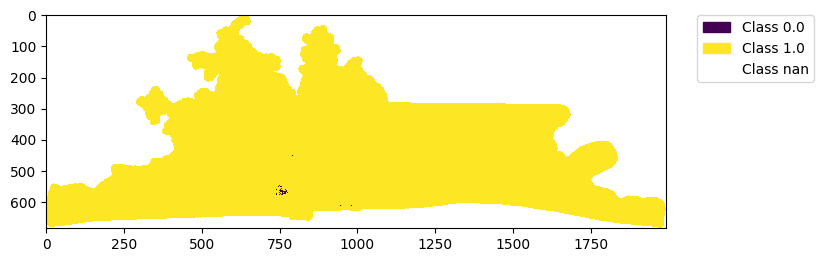

In [24]:
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

h = img_arr.shape[1]
w = img_arr.shape[2]

pred_map = predictions_image.reshape(h, w)


values = np.unique(pred_map.ravel())

plt.figure(figsize=(8,4))
im = plt.imshow(pred_map, interpolation='none')

# get the colors of the values, according to the
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color
patches = [ mpatches.Patch(color=colors[i], label="Class {l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()

In [40]:
import datetime
import rasterio as rio
T = datetime.datetime.now()
time = T.strftime("%y%m%d%H%M%S")
MPATH = '/media/owusu/Extreme SSD/IDEAMAPS/outputs/accra_maps'
filename = 'nai_catboost_subset_11'
out_file = f"{MPATH}/{filename}_{time}.tif"
# out_file = "/home/ubuntu/max/output/lag_lgb_map.tif"
# update profile from red band
fp = f'/media/owusu/Extreme SSD/IDEAMAPS/covariate_feature_53bands/nai_covariate_compilation_53bands.tif'
with rio.open(fp, mode="r") as src:
    out_profile = src.profile.copy()
    out_profile.update(count=1,
                       nodata=-9999,
                       dtype='float32',
                       width=src.width,
                       height=src.height,
                       crs=src.crs)

# open in 'write' mode, unpack profile info to dst
with rio.open(out_file,
                   'w', **out_profile) as dst:
    dst.write_band(1, pred_map)